# Demo: Language Modeling
Demostrate typical usages for debugging a Language Model

### Defining a wrapper to use diagnostics tools

In [1]:
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F


class GPT2LMModelWrapper(nn.Module):
    def __init__(self, model) -> None:
        super(GPT2LMModelWrapper, self).__init__()
        self.m = model

    def forward(self, inputs_embeds, attention_mask) -> Tensor:
        output = self.m(
            inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).logits[:, -1, :]
        return F.softmax(output, -1)

### Language Modeling predicting next word using gpt2

In [2]:
import transformers
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

text_input = "Can humans dream of electric sheep ? I think"
# text_input = "This knife is very"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", return_dict=True, is_decoder=True)

inputs = tokenizer(text_input, return_tensors="pt")
output = model(**inputs).logits[:, -1, :]
softmax = F.softmax(output, -1)
values, predictions = softmax.topk(3)

for i, v in enumerate(values[0]):
    p = predictions[0][i]
    x = tokenizer.decode(p)
    print("prediction:", x, " prob:", v.item())

prediction:  so  prob: 0.27135252952575684
prediction:  it  prob: 0.12552329897880554
prediction:  that  prob: 0.08452347666025162


In [3]:
from diagnostics import get_gradients

md = GPT2LMModelWrapper(model)
# Use zero logits as baseline
baseline = torch.zeros((1, tokenizer.vocab_size))
# Set target to highest prob prediction
target = torch.zeros((1, tokenizer.vocab_size))
target[0][predictions[0][0]] = 1
# Preprocess inputs ids to embedings, otherwise we can't get gradients
inputs_embeds = model.transformer.wte(inputs["input_ids"])
gradients = get_gradients(
    md, [inputs_embeds, inputs["attention_mask"]], baseline, target
)
input_grad = torch.sum(gradients[0], 2)

0
torch.Size([1, 50257])
tensor(0.2714, grad_fn=<SelectBackward0>)


In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_gradients(tokens, gradients, title):
    plt.figure(figsize=(21, 3))
    xvals = [x + str(i) for i, x in enumerate(tokens)]
    norm_grad = (gradients - np.min(gradients)) / (
        np.max(gradients) - np.min(gradients)
    )
    colors = [(0, 0, 1, c) for c in (norm_grad)]
    plt.tick_params(axis="both", which="minor", labelsize=29)
    p = plt.bar(xvals, gradients, color=colors, linewidth=1)
    plt.title(title)
    p = plt.xticks(
        ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12, rotation=0
    )

In [5]:
tokens = []
for i in inputs["input_ids"][0]:
    tokens.append(tokenizer.decode(i))

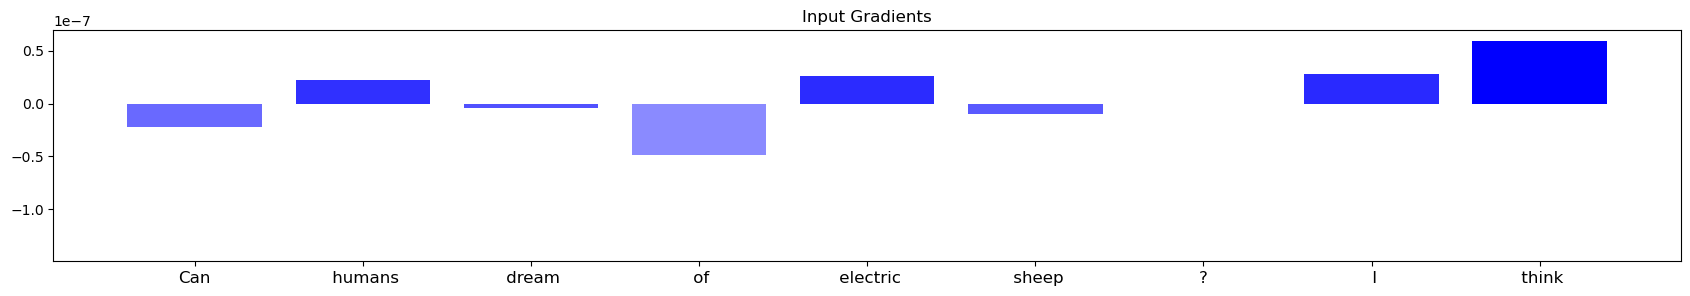

In [6]:
plot_gradients(tokens, input_grad[0].numpy(), "Input Gradients")